#Experiment

This notebook takes a VQC with Pauli encoding gates that is decently large ($|\Omega| \sim 200$) and performs the various approximation algorithm outlined in the paper.

#Imports

In [85]:
!pip install pennylane
!pip install treelib

In [86]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.fourier import circuit_spectrum

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import random

In [87]:
from numpy import random

In [88]:
#lecture 8 helper, put in here for convenience

def plot_data(data, labels):
    """Plot the data and colour by class.
    
    Args:
        data (array[float]): Input data. A list with shape N x 2
            representing points on a 2D plane.
        labels (array[int]): Integers identifying the class/label of 
            each data point.
    """
    plt.scatter(data[:, 0], data[:, 1], c=labels)


def make_predictions(data, model, weights):
    """Predict the labels of all points in a data set for a given model.
    
    Args:
        data (array[float]): Input data. A list with shape N x 2
            representing points on a 2D plane.
        model (qml.QNode): A QNode whose output expectation value will be
            used to make predictions of the labels of data.
        weights (array[float]): The trainable model parameters for the QNode. 
            
    Returns:
        array[int]: The array of predictions for each data point made by 
        the model QNode. 
    """
    preds = []
    
    for idx in range(len(data)):
        estimated_expval = model(data[idx], weights)
        
        if estimated_expval > 0:
            preds.append(1)
        else:
            preds.append(-1)
            
    return preds


def compute_accuracy(predictions, true_labels):
    """Compute the accuracy of our predictions.
    
    Args:
        predictions (array[int]): Predicted values to 
        true_labels (array[int]): Integers identifying the class/label of 
            each data point.
    
    Returns:
        float: Accuracy of the predictions, returned as a percentage.
    """    
    n_samples = len(predictions)
    
    return np.sum(
        [predictions[x] == true_labels[x] for x in range(n_samples)
    ]) / n_samples


def make_loss_function(data, labels, model):

    def loss(weights):
        loss_sum = 0.0

        for idx in range(len(data)):
            point = data[idx]
            true_expval = labels[idx]

            estimated_expval = model(point, weights)
            loss_sum += (estimated_expval - true_expval) ** 2

        return loss_sum / len(data)
    
    return loss

#Construction of a target function

We construct a target function of degree 100, allowing $$|\Omega| = 203$$


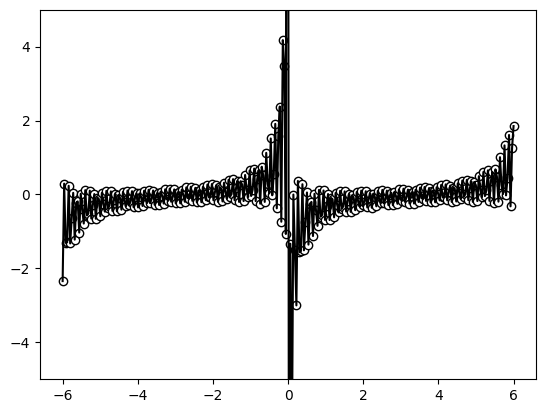

In [89]:
# This part of the code prints the graph we are trying to approximate

degree = 100  # degree of the target function
scaling = 1  # scaling of the data
coeffs = [0.15 + 0.15j]*degree  # coefficients of non-zero frequencies
coeff0 = 0.1  # coefficient of zero frequency

def target_function(x):
    """Generate a truncated Fourier series, where the data gets re-scaled."""
    res = coeff0
    for idx, coeff in enumerate(coeffs):
        exponent = np.complex128(scaling * (idx+1) * x * 1j)
        conj_coeff = np.conjugate(coeff)
        res += coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent)
    return np.real(res)

x = np.linspace(-6, 6, 300)
target_y = np.array([target_function(x_) for x_ in x])


plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.ylim(-5, 5)
plt.show()

#Algorithim One 

In this section of the code we define the circuit with a variable n_layers and then get the frequencies folowing algorithim one outlined in the paper

In [90]:
#This is a VQC that changes based on the input n_layers which changes how many frequencies we can sample.

import pennylane as qml
import numpy as np

n_layers = 100
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def circuit(x, weights):
    for l in range(n_layers):
        qml.RX(x, wires=0, id="x"+str(0))
        qml.Rot(weights[l,0,0], weights[l,0,1], weights[l,0,2], wires=0)
    qml.RZ(x, wires=0, id="x0")
    return qml.expval(qml.PauliZ(wires=0))

x = 1
weights = np.random.random((n_layers, 1, 3))
res = qml.fourier.circuit_spectrum(circuit)(x, weights)

print(qml.draw(circuit)(x, weights))
for inp, freqs in res.items():
    print(f"{inp}: {freqs}")

0: ──RX(1.00)──Rot(0.02,0.31,1.00)──RX(1.00)──Rot(0.02,0.68,0.06)──RX(1.00)──Rot(0.01,0.47,0.38)

───RX(1.00)──Rot(0.56,0.15,0.87)──RX(1.00)──Rot(0.81,0.83,0.09)──RX(1.00)──Rot(0.05,0.76,0.31)

───RX(1.00)──Rot(0.31,0.39,0.46)──RX(1.00)──Rot(0.78,0.69,0.91)──RX(1.00)──Rot(0.34,0.47,0.17)

───RX(1.00)──Rot(0.98,0.80,0.15)──RX(1.00)──Rot(0.47,0.15,0.63)──RX(1.00)──Rot(0.52,0.81,0.50)

───RX(1.00)──Rot(0.85,0.57,0.15)──RX(1.00)──Rot(0.91,0.18,0.72)──RX(1.00)──Rot(0.80,0.65,0.03)

───RX(1.00)──Rot(0.02,0.63,0.54)──RX(1.00)──Rot(0.97,0.92,0.09)──RX(1.00)──Rot(0.52,0.53,0.55)

───RX(1.00)──Rot(0.87,0.03,0.32)──RX(1.00)──Rot(0.42,0.85,0.20)──RX(1.00)──Rot(0.44,0.07,0.32)

───RX(1.00)──Rot(0.38,0.43,0.24)──RX(1.00)──Rot(0.41,0.50,0.51)──RX(1.00)──Rot(0.90,0.03,0.89)

───RX(1.00)──Rot(0.13,0.88,0.26)──RX(1.00)──Rot(0.62,0.28,0.72)──RX(1.00)──Rot(0.10,0.46,0.59)

───RX(1.00)──Rot(0.04,0.29,0.13)──RX(1.00)──Rot(0.72,0.56,0.97)──RX(1.00)──Rot(1.00,0.62,0.98)

───RX(1.00)──Rot(0.33,0.08,0.68)──RX(1

#Algorithim 2 tree sampling

In [91]:
from treelib import Node, Tree

#The tree_sampling function creates a tree and then following the algorithim defined in the paper it creates and returns an array of frequencies that we can sample from.
def tree_sampling(n_layers):
    #Create a 2d array of eigenvalues
    eigvals_array = []

    for i in range(n_layers):
        pauli_x_eigval = qml.eigvals(qml.PauliX(wires=0))/2
        eigvals_array.append(pauli_x_eigval)

    pauli_z_eigval = qml.eigvals(qml.PauliZ(wires=0))/2
    eigvals_array.append(pauli_z_eigval)

    # Create the tree from the eigvals_array
    # The depth of the tree will be n_layers + 1
    def create_tree(eigvals, parent, depth):
        if len(eigvals) == 0:
            return None

        first, *rest = eigvals

        for i in range(len(first)):
            node_name = parent + "_" + str(first[i]) + "_" + str(depth)
            tree.create_node(node_name, node_name, parent=parent, data=first[i])
            create_tree(rest, node_name, depth+1)

    tree = Tree()
    tree.create_node("root", "root", data=0)  # root node
    create_tree(eigvals_array, "root", 1)

    # Function to sum the data values along each unique path starting from the leaves
    def sum_from_leaves(tree, leaf_node):
        path_sum = leaf_node.data
        current_node = leaf_node

        while str(current_node.identifier) != "root":
            parent = tree.parent(current_node.identifier)
            path_sum += parent.data
            current_node = parent

        return path_sum

    upperCaseLambdaArray = []
    # Calculate and print the sum of data values for each unique path starting from the leaves
    for leaf in tree.leaves():
        sum = sum_from_leaves(tree, leaf)
        upperCaseLambdaArray.append(sum)

    frequencyArray = []
    #Create frequency array
    for i in range(len(upperCaseLambdaArray)):
        for j in range(len(upperCaseLambdaArray)):
            frequency = upperCaseLambdaArray[i] - upperCaseLambdaArray[j]
            frequencyArray.append(frequency)

    return frequencyArray

layersTree = 5
frequencyArray = tree_sampling(layersTree)

#Algorithm 3 grid sampling

In [92]:
#Helper function to create a range of floats for Algorithm 3
def range_with_floats(start, stop, step):
    while stop >= start:
        yield start
        start += step

#Algorithim 3
#Number of layers

#For the circuit we use with each algorithm the number of encoding gates is number of layers + 1
#This is because we have one additional encoding gate RZ.
numberOfEncodingGates = n_layers + 1

#Because the eigenvalues of PauliX and PauliZ gates are -0.5 and 0.5 we know that w_max is numberOfEncodingGates
wMax = numberOfEncodingGates

#We need to assign a step value a resonable step value is anywhere from 0 to 1
step = 0.1

grid = []

#Create the grid
for i in range_with_floats(0, wMax, step):
    grid.append(i)


#Constructing the approximation function

Classically training the approximation function to prepare for the algorithms. There is no gradient descent, as we can compute the optimization algorithm by explicitly computing $w$.

In [93]:
def construct_phi(x, frequencies):
  #constructs phi or tilde_phi 
  #based on x and the given frequencies

  phi = np.zeros(2* len(frequencies))
  for i in range(len(frequencies)):
    phi[2*i] = np.cos(frequencies[i] * x)
    phi[2*i+1] = np.sin(frequencies[i] * x)
  
  return phi

def construct_Phi(xi_array, frequencies):
  M = len(xi_array)
  P = 2*len(frequencies)
  Phi = np.zeros((M, P))

  for i in range(M):
    phi = construct_phi(xi_array[i], frequencies)
    for j in range(P):
      Phi[i][j] = phi[j]
  return Phi

def construct_w(xi_array, yi_array, frequencies):
  M = len(xi_array)
  P = 2*len(frequencies)
  Phi = construct_Phi(xi_array, frequencies)
  lambda_hyper = 0.001

  Phi_T = np.transpose(Phi)

  w_1 = np.matmul(Phi_T, Phi) + M*lambda_hyper * np.identity(P)
  w_2 = np.matmul(np.linalg.inv(w_1), Phi_T)
  w = np.matmul(w_2, yi_array)
  return w

def f(x, w, frequencies):
  phi = construct_phi(x, frequencies)
  return np.matmul(w, phi)

In [94]:
def construct_f(xi_array, yi_array, frequencies):
  w = construct_w(xi_array, yi_array, frequencies)
  def f(x):
    phi = construct_phi(x, frequencies)
    return np.matmul(w, phi)
  return f

#Plot of one such f to get a sanity check

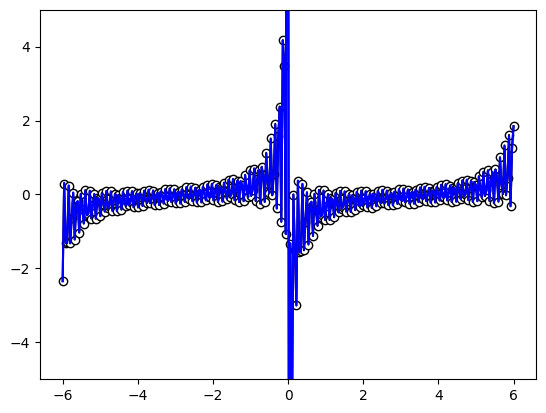

In [95]:
x = np.linspace(-6, 6, 300)
target_y = np.array([target_function(x_) for x_ in x])

frequencies = res['x0']

f = construct_f(x, target_y, frequencies)
target_y_f = np.array([f(x_) for x_ in x])

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.ylim(-5, 5)

plt.plot(x, target_y_f, c='blue')
plt.show()

#Define the loss function 
The loss function is the L2 loss. Taken in Lecture 8 helpers.

In [96]:
def loss_given_frequencies(x, target_y, frequencies):
    loss_sum = 0.0

    f = construct_f(x, target_y, frequencies)

    for idx in range(len(x)):
        point = x[idx]
        true_expval = target_y[idx]

        estimated_expval = f(point)
        loss_sum += (estimated_expval - true_expval) ** 2

    return loss_sum / len(x)


#Compute the losses!

For distinct sampling: we sample more and more frequencies from $\Omega$, and compute the loss for each number of frequency we sample. At the end, we sampled all frequencies and the loss will be 0.

For tree sampling: since we use the same Pauli encoding gates over and over, each path of the tree represents a linear combination of -1 and 1. So we can model it using a binomial distribution. 

For grid sampling, as in the paper, we can take $s = 0.1$

In [97]:
x_loss_graph = np.linspace(1, 203, 203)

for i in range(1):
  random.shuffle(frequencies)
  tree_frequencies = []
  grid_frequencies = []
  y_loss_distinct = []
  y_loss_tree = []
  y_loss_grid = []
  grid_frequencies.append(random.choice(grid))

  for j in range(len(frequencies)):


    grid_frequencies.append(random.choice(grid))
    loss_grid = loss_given_frequencies(x, target_y, grid_frequencies[0:j+1])
    y_loss_grid.append(loss_grid)

    freq_binomial = random.binomial(203, 0.5) - 102
    tree_frequencies.append(freq_binomial)
    loss_tree = loss_given_frequencies(x, target_y, tree_frequencies[0:j+1])
    y_loss_tree.append(loss_tree)

    loss_distinct = loss_given_frequencies(x, target_y, frequencies[0:j+1])
    y_loss_distinct.append(loss_distinct)

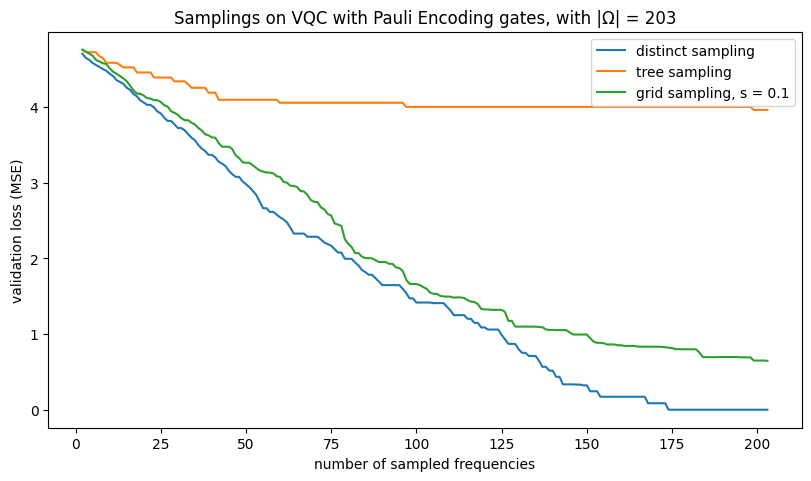

In [98]:
#Code referenced official documentation of Matplotlib

fig, ax = plt.subplots(figsize=(8, 4.7), layout='constrained')
ax.plot(x_loss_graph[1:], y_loss_distinct[1:], label='distinct sampling')  
ax.plot(x_loss_graph[1:], y_loss_tree[1:], label='tree sampling') 
ax.plot(x_loss_graph[1:], y_loss_grid[1:], label='grid sampling, s = 0.1') #grid sampling with 1 sample looks wrong, removed.
ax.set_xlabel('number of sampled frequencies')  
ax.set_ylabel('validation loss (MSE)')  
ax.set_title("Samplings on VQC with Pauli Encoding gates, with |Ω| = 203") 
ax.legend()